# Importing data

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from IPython.display import display
import plotly.express as px
from datetime import datetime
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

In [3]:
CURR_DIR = os.getcwd()
DATA_DIR = os.path.join(CURR_DIR, 'Datasets')

In [4]:
btc = pd.read_csv(os.path.join(DATA_DIR,'btc.csv'),float_precision='high')
eth = pd.read_csv(os.path.join(DATA_DIR,'eth.csv'),float_precision='high')
ada = pd.read_csv(os.path.join(DATA_DIR,'ada.csv'),float_precision='high')
xrp = pd.read_csv(os.path.join(DATA_DIR,'xrp.csv'),float_precision='high')
bnb = pd.read_csv(os.path.join(DATA_DIR,'bnb.csv'),float_precision='high')

In [5]:
drop_features= ['textBlob_polarity','textBlob_subjectivity',
          'vader_compound','vader_negative_score','vader_positive_score','vader_neutral_score',
          'finbert_text_label','finbert_title_label','textBlob_label','vader_label','lm_label',
          'finBert_title_positive_score','finBert_title_negative_score','finBert_title_neutral_score']
btc.drop(drop_features,axis=1, inplace=True)
eth.drop(drop_features,axis=1, inplace=True)
ada.drop(drop_features,axis=1, inplace=True)
xrp.drop(drop_features,axis=1, inplace=True)
bnb.drop(drop_features,axis=1, inplace=True)

# Identification

In [6]:
btc.date = pd.to_datetime(btc.date, infer_datetime_format=True)
eth.date = pd.to_datetime(eth.date, infer_datetime_format=True)
xrp.date = pd.to_datetime(xrp.date, infer_datetime_format=True)
ada.date = pd.to_datetime(ada.date, infer_datetime_format=True)
bnb.date = pd.to_datetime(bnb.date, infer_datetime_format=True)

In [7]:
btc.set_index('date',inplace=True)
btc.sort_index(inplace=True)

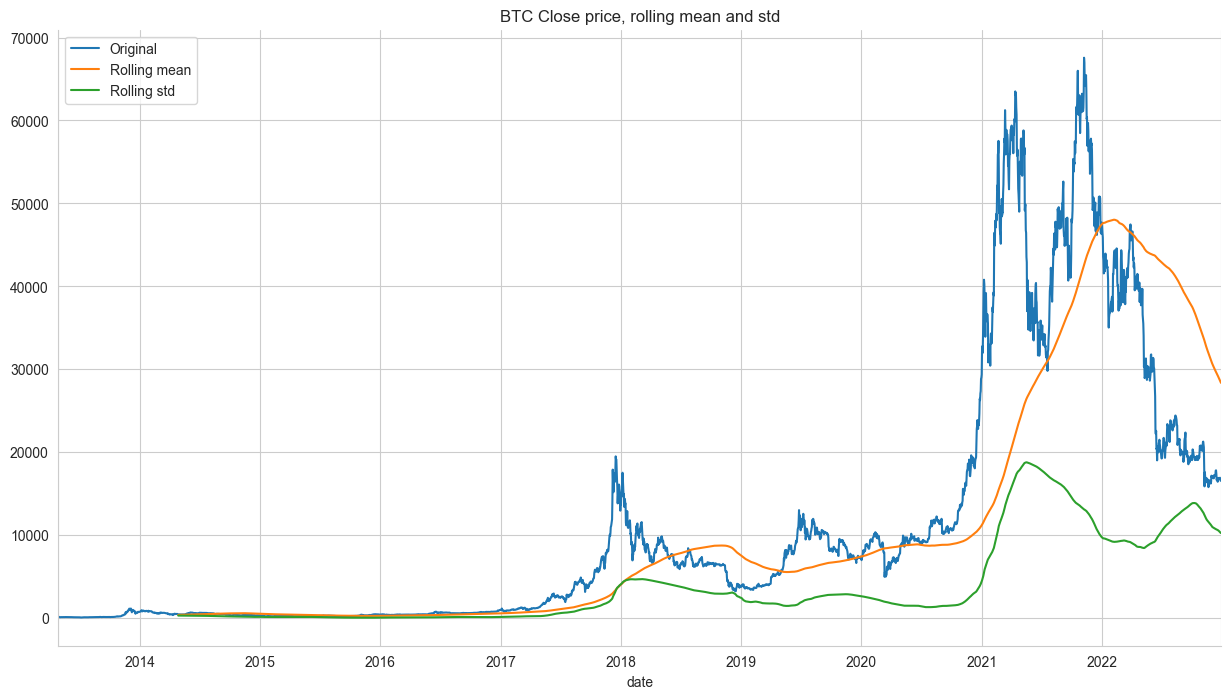

In [8]:
btc.close.plot(figsize = (15, 8))
btc.close.rolling(window=365).mean().plot()
btc.close.rolling(window=365).std().plot()
plt.legend(['Original', 'Rolling mean', 'Rolling std'])
plt.title('BTC Close price, rolling mean and std')
sns.despine()
plt.show()

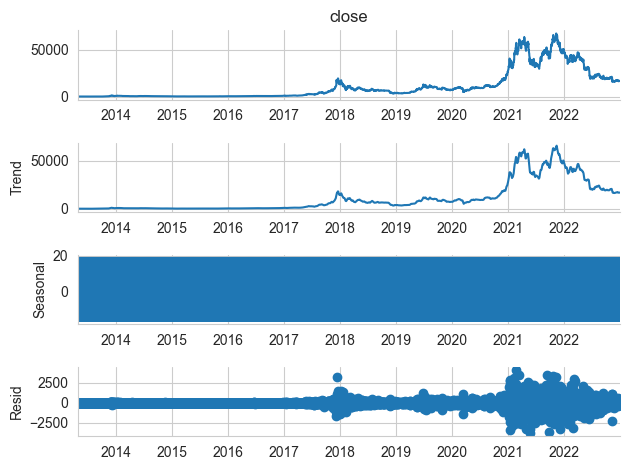

In [9]:
decomp_result = seasonal_decompose(btc.close,extrapolate_trend='freq')
decomp_result.plot()
sns.despine()
plt.show()

- We can observe an upward trend 
- We can't identify any seasonal pattern from the plot
    - The ts is probably to noisy. Hence we will resample the daily data to monthly data
- Result: TS is not stationary

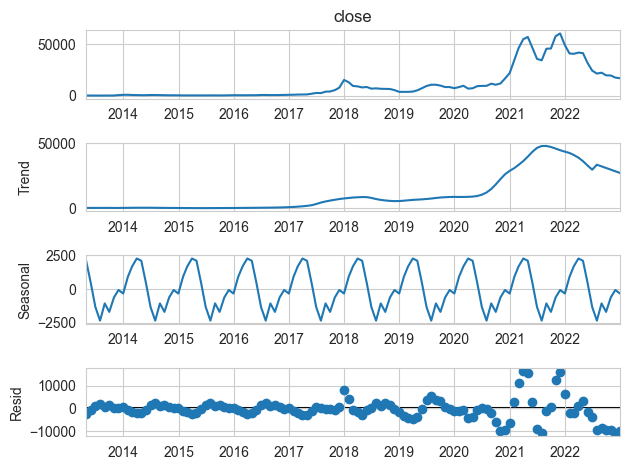

In [10]:
btc_monthly = btc.resample('M').mean()
btc_monthly = btc_monthly.close
decomp_monthly = seasonal_decompose(btc_monthly, extrapolate_trend='freq')
decomp_monthly.plot()
plt.show()

- We can observe an upward trend and a seasonal pattern
- Result TS is not stationary

Stationary Test
- data doesn't change with time (zero trend, not growing/shrinking, variance is constant)

In [11]:
# Dickey Fuller Test
def adfuller_test(data):
# https://github.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/blob/master/Untitled.ipynb
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

def kpps_test(data):
    result = kpss(data, regression='ct')
    print('\nKPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critial Values:' ,result[3:])
    if result[1] >= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [12]:
adfuller_test(btc.close)
kpps_test(btc.close)

ADF Test Statistic : -1.6629808850382952
p-value : 0.4502796178231691
#Lags Used : 29
Number of Observations Used : 3503
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

KPSS Statistic: 0.783456
p-value: 0.010000
Critial Values: ({'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216},)
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [13]:
adfuller_test(btc_monthly)
kpps_test(btc_monthly)

ADF Test Statistic : -1.6241048575094095
p-value : 0.47057794244079254
#Lags Used : 2
Number of Observations Used : 114
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 

KPSS Statistic: 0.183468
p-value: 0.022200
Critial Values: ({'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216},)
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In order to make the ts stationary we will use the returns
- https://stats.stackexchange.com/questions/465514/why-prices-are-usually-not-stationary-but-returns-are-more-likely-to-be-station

Transformation

In [14]:
returns = btc.close.pct_change().to_frame().dropna()
retuns_monthly = btc.close.resample('M').mean()
retuns_monthly = retuns_monthly.pct_change().to_frame().dropna()

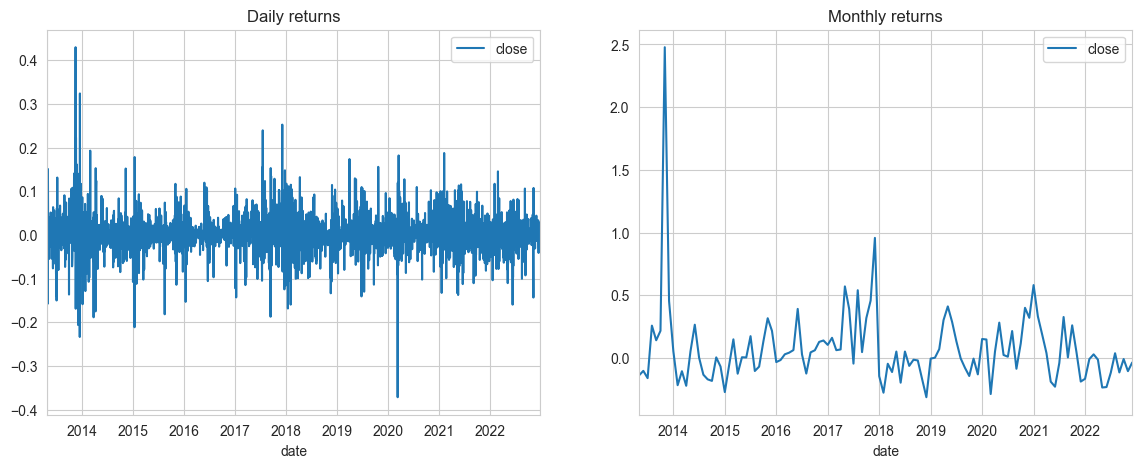

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
returns.plot(ax=ax[0])
retuns_monthly.plot(ax=ax[1])
ax[0].set_title('Daily returns')
ax[1].set_title('Monthly returns')
plt.show()

In [16]:
adfuller_test(returns)
kpps_test(returns)

ADF Test Statistic : -9.646136939436127
p-value : 1.4761395538195812e-16
#Lags Used : 30
Number of Observations Used : 3501
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary

KPSS Statistic: 0.089724
p-value: 0.100000
Critial Values: ({'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216},)
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [17]:
adfuller_test(retuns_monthly)
kpps_test(retuns_monthly)

ADF Test Statistic : -7.856411988423583
p-value : 5.427831210316305e-12
#Lags Used : 0
Number of Observations Used : 115
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary

KPSS Statistic: 0.048762
p-value: 0.100000
Critial Values: ({'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216},)
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [18]:
# Check again
print('Differencing (Daily):', ndiffs(btc.close, test="adf"),'\n')
print('Differencing (Monthly):', ndiffs(btc_monthly, test="adf"))

Differencing (Daily): 1 

Differencing (Monthly): 1


Autocorrelation 
- Correlation between ts and same ts offset by x step(lag)

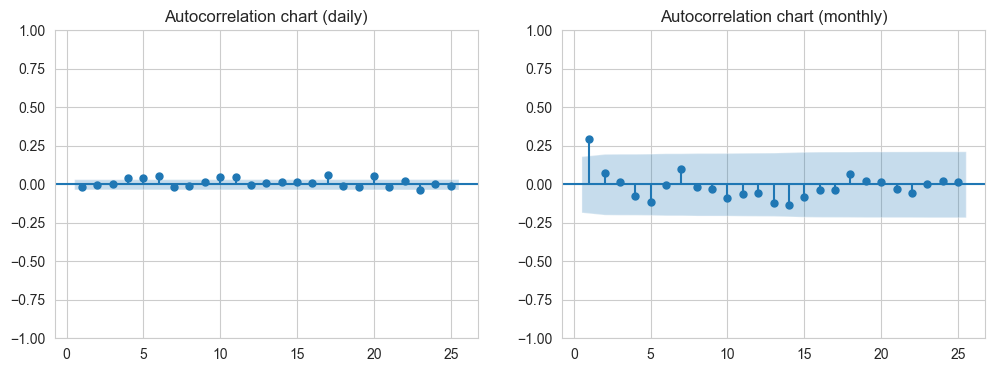

In [19]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(returns,lags=25, zero=False,title="Autocorrelation chart (daily)",ax=ax[0])
plot_acf(retuns_monthly,lags=25, zero=False,title="Autocorrelation chart (monthly)",ax=ax[1])
plt.show()

- We can observe that the acf lag 4 is statistically significant for daily data abd the acf lag 1 is significant for monthly data (MA part)

Partial Autocorrelation
- Correlation between ts and the lagged version of itself after subtract the effect of correlation at smaller lags
- Correaltion with just that particula lag

C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


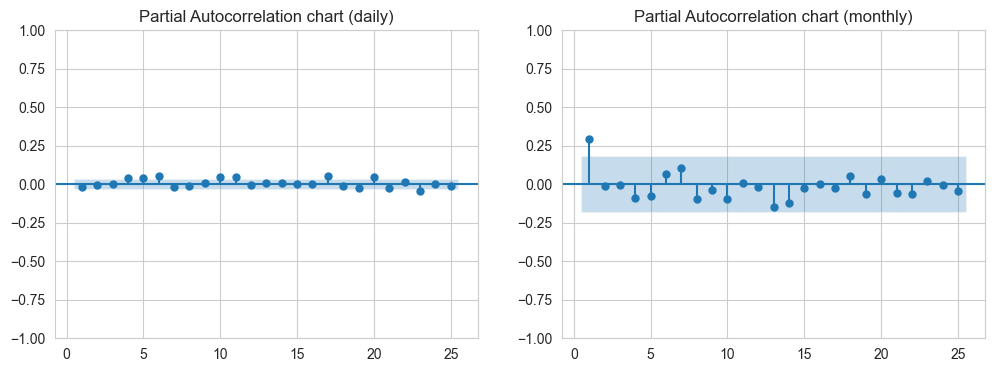

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_pacf(returns,lags=25, zero=False,title="Partial Autocorrelation chart (daily)",ax=ax[0])
plot_pacf(retuns_monthly,lags=25, zero=False,title="Partial Autocorrelation chart (monthly)",ax=ax[1])
plt.show()

- We can observe that the pacf lag 4 for daily data and lg 1 monthly data (AR part)

# Pmdarima

- We will use pmdarima with a machine learning approach to build the models
- Reference: 
    - https://alkaline-ml.com/pmdarima/usecases/stocks.html
    - https://datascience.stackexchange.com/questions/53144/do-we-have-to-split-our-dataset-into-training-testing-when-using-arima-model

## Daily Model

In [22]:
split = int(len(btc)*0.8)
train_daily, test_daily = btc.iloc[:split].close, btc.iloc[split:].close
print(train_daily.shape, test_daily.shape)

(2826,) (707,)


In [23]:
model_daily = pm.auto_arima(train_daily,
                        d=1,
                        start_p=0,
                        start_q=0,
                        max_p=10,
                        max_q=10,
                        seasonal=False,
                        information_criterion='aic',
                        trace = True,
                        error_action='ignore',
                        stepwise = True,
                        max_order=None,
                        random_state=42)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40721.328, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40681.642, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40677.986, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40722.459, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40678.532, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=40677.771, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=40678.901, Time=0.95 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=40677.706, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=40679.464, Time=1.22 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=40677.899, Time=0.47 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=40665.251, Time=3.69 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=40619.384, Time=4.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=40642.005, Time=3.39 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=40623.862, Time=5.50 sec
 ARIMA(2,1,5)(0,0,0

In [24]:
model_daily.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2826
Model:               SARIMAX(2, 1, 4)   Log Likelihood              -20301.692
Date:                Sun, 29 Jan 2023   AIC                          40619.384
Time:                        17:29:56   BIC                          40666.954
Sample:                    04-28-2013   HQIC                         40636.547
                         - 01-21-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.2333      6.185      1.654      0.098      -1.890      22.356
ar.L1          1.1148      0.004    248.433      0.000       1.106       1.124
ar.L2         -0.9531      0.004   -216.913      0.000      -0.962      -0.945
ma.L1         -0.9895      0.008   -117.748      0.000      -1.006      -0.973
ma.L2          0.7948      0.012     65.834      0.000       0.771       0.818
ma.L3          0.1321      0.011     11.820      0.000       0.110       0.154
ma.L4          0.0348      0.007      4.744      0.000       0.020       0.049
sigma2      1.049e+05    752.707    139.361      0.000    1.03e+05    1.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            149981.16
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             260.07   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

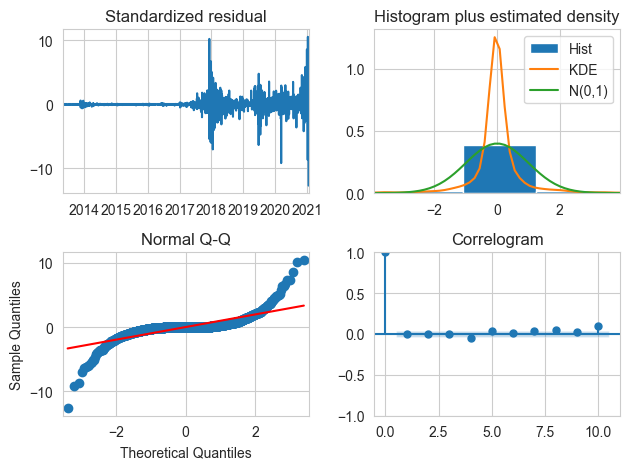

In [25]:
model_daily.plot_diagnostics()
plt.tight_layout()
plt.show()

In [26]:
#https://alkaline-ml.com/pmdarima/usecases/stocks.html
def forecast_one_step(pm_model, n_periods=1):
    model = pm_model
    fc, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    return (fc.tolist()[0],np.asarray(conf_int).tolist()[0])

def forecast_test(pm_model,test):
    forecasts = []
    confidence_intervals = []
    model = pm_model
    
    for new_ob in test:
        fc, conf = forecast_one_step(model)
        forecasts.append(fc)
        confidence_intervals.append(conf)
        # Updates the existing model with a small number of MLE steps
        model.update(new_ob)
    print(f"Mean squared error: {mean_squared_error(test, forecasts)}")
    return forecasts, confidence_intervals

In [27]:
forecasts, confidence_intervals = forecast_test(model_daily,test_daily)

Mean squared error: 2341028.3350122715


In [28]:
f_data = pd.DataFrame({'dates':test_daily.index, 'forecast':forecasts})
f_data.set_index('dates',inplace=True)

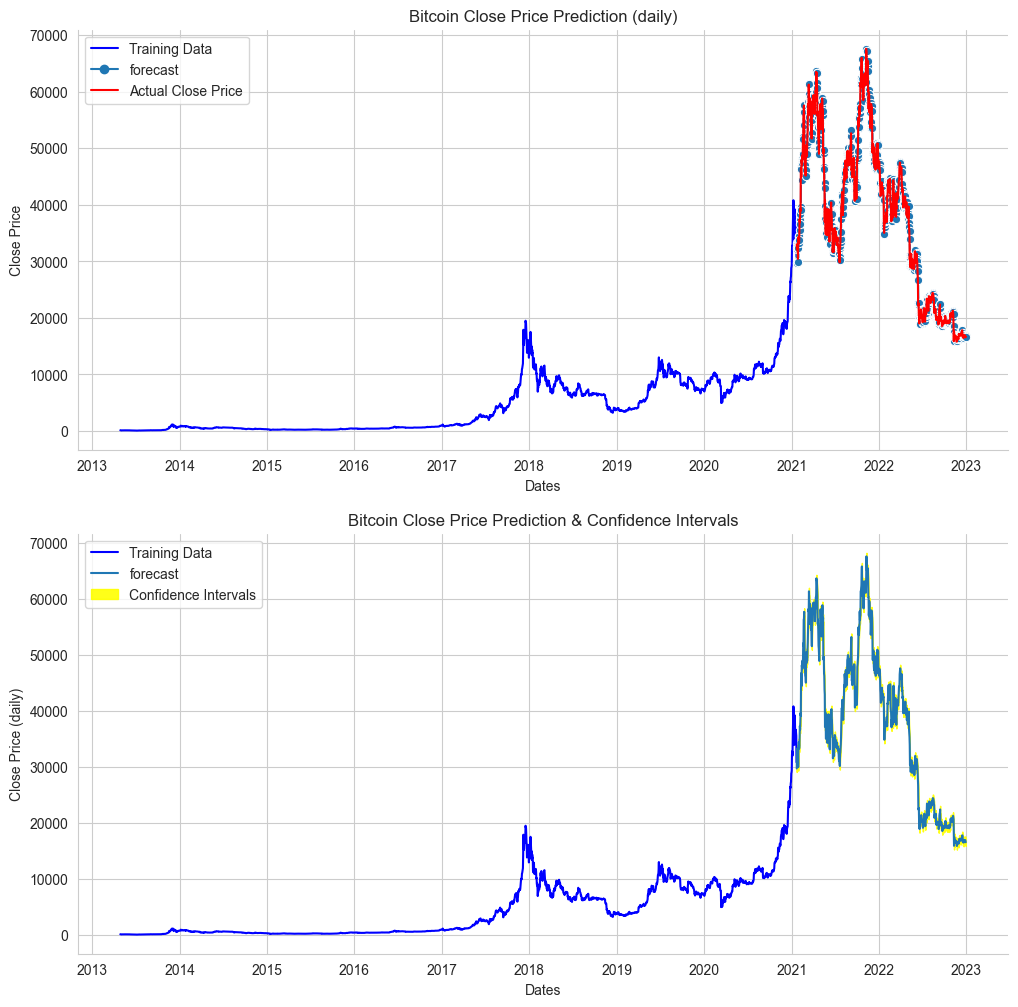

In [29]:
#https://alkaline-ml.com/pmdarima/usecases/stocks.html
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.lineplot(train_daily, color='blue', label='Training Data', ax=axes[0])
sns.lineplot(f_data, markers=True,color='green', ax=axes[0])
sns.lineplot(test_daily, color='red', label='Actual Close Price', ax=axes[0])

axes[0].set_title('Bitcoin Close Price Prediction (daily)')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Close Price')
axes[0].legend()

sns.lineplot(train_daily, color='blue', label='Training Data', ax=axes[1])
sns.lineplot(f_data,color='green', ax=axes[1])
axes[1].set_title('Bitcoin Close Price Prediction & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Close Price (daily)')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_daily.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='yellow',
                     label="Confidence Intervals")

axes[1].legend()
sns.despine()
plt.show()

In [30]:
date = [datetime(2022,12,30),datetime(2022,12,31), datetime(2023,1,1),datetime(2023,1,2),datetime(2023,1,3),
        datetime(2023,1,4),datetime(2023,1,5),datetime(2023,1,6),datetime(2023,1,7)]
df = pd.DataFrame({'date':date})

In [31]:
predictions =[]
ci_intervals=[]
for i in range(1,10):
    prediction, confidence_intervals= forecast_one_step(model_daily, n_periods=i)
    model_daily.update(prediction)
    predictions.append(prediction)
    #print(df.iloc[i-1])
    ci_intervals.append(confidence_intervals)

In [32]:
df['predictions'] = predictions
#df.set_index('date',inplace=True)
all = pd.concat([train_daily.to_frame(),test_daily.to_frame(),df.set_index('date')])

In [47]:
all

close   predictions
date                                  
2013-04-30    139.250000           NaN
2013-05-31    119.992741           NaN
2013-06-30    107.761407           NaN
2013-07-31     90.512207           NaN
2013-08-31    113.905484           NaN
...                  ...           ...
2022-12-31  16975.440994           NaN
2023-01-31           NaN  16866.138835
2023-02-28           NaN  17142.024349
2023-03-31           NaN  17146.383862
2023-04-30           NaN  16906.709308

[121 rows x 2 columns]

In [33]:
fig = px.line(all.iloc[-80:],title='BTC Close: 9 days forecast').update_layout(xaxis_title='Date',yaxis_title='Close')
fig.show()

## Monthly model

In [35]:
split = int(len(btc_monthly)*0.8)
train_monthly, test_monthly = btc_monthly.iloc[:split], btc_monthly.iloc[split:]
print(train_monthly.shape, test_monthly.shape)

(93,) (24,)


In [36]:
model_monthly= pm.auto_arima(train_monthly,
                        d=None,
                        start_p=1,
                        start_q=1,
                        max_p=10,
                        max_q=10,
                        seasonal=True,
                        information_criterion='aic',
                        trace = True,
                        error_action='ignore',
                        stepwise = True,
                        m=12,
                        D=None,
                        start_P=1,
                        start_Q=1,
                        max_P=10,
                        max_Q=10
                       )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1590.485, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1596.193, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1590.486, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1587.145, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1596.858, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1587.446, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1588.601, Time=0.53 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1587.598, Time=0.34 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1588.091, Time=0.11 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1595.287, Time=0.09 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1588.755, Time=0.19 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=1588.941, Time=0.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1589.800, Time=0.11 sec
 ARIMA(1,1,2)(0,0,1)[12]

In [37]:
model_monthly= pm.auto_arima(btc_monthly,
                        d=None,
                        start_p=1,
                        start_q=1,
                        max_p=10,
                        max_q=10,
                        seasonal=True,
                        information_criterion='aic',
                        trace = True,
                        error_action='ignore',
                        stepwise = True,
                        m=12,
                        D=None,
                        start_P=1,
                        start_Q=1,
                        max_P=10,
                        max_Q=10
                       )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2197.964, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2227.143, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2199.860, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2196.931, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2225.345, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2196.906, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2197.144, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2198.734, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2197.056, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=2196.960, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2200.308, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2198.767, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=2195.012, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=2195.200, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1

In [38]:
model_monthly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  117
Model:             SARIMAX(2, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -1091.577
Date:                              Sun, 29 Jan 2023   AIC                           2191.154
Time:                                      17:42:59   BIC                           2202.168
Sample:                                  04-30-2013   HQIC                          2195.625
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6341      0.060     10.498      0.000       0.516       0.753
ar.L2         -0.2656      0.040     -6.595      0.000      -0.345      -0.187
ma.S.L12       0.1776      0.093      1.902      0.057      -0.005       0.361
sigma2      9.116e+06   6.02e+05     15.132      0.000    7.93e+06    1.03e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               291.90
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):            3059.81   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

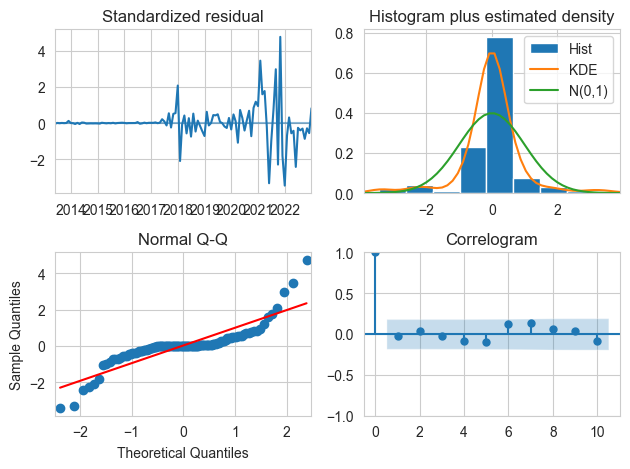

In [39]:
model_monthly.plot_diagnostics()
plt.tight_layout()
plt.show()

In [40]:
forecasts, confidence_intervals = forecast_test(model_monthly,test_monthly)

Mean squared error: 45394977.5392692


In [41]:
f_data = pd.DataFrame({'dates':test_monthly.index, 'forecast':forecasts})
f_data.set_index('dates',inplace=True)

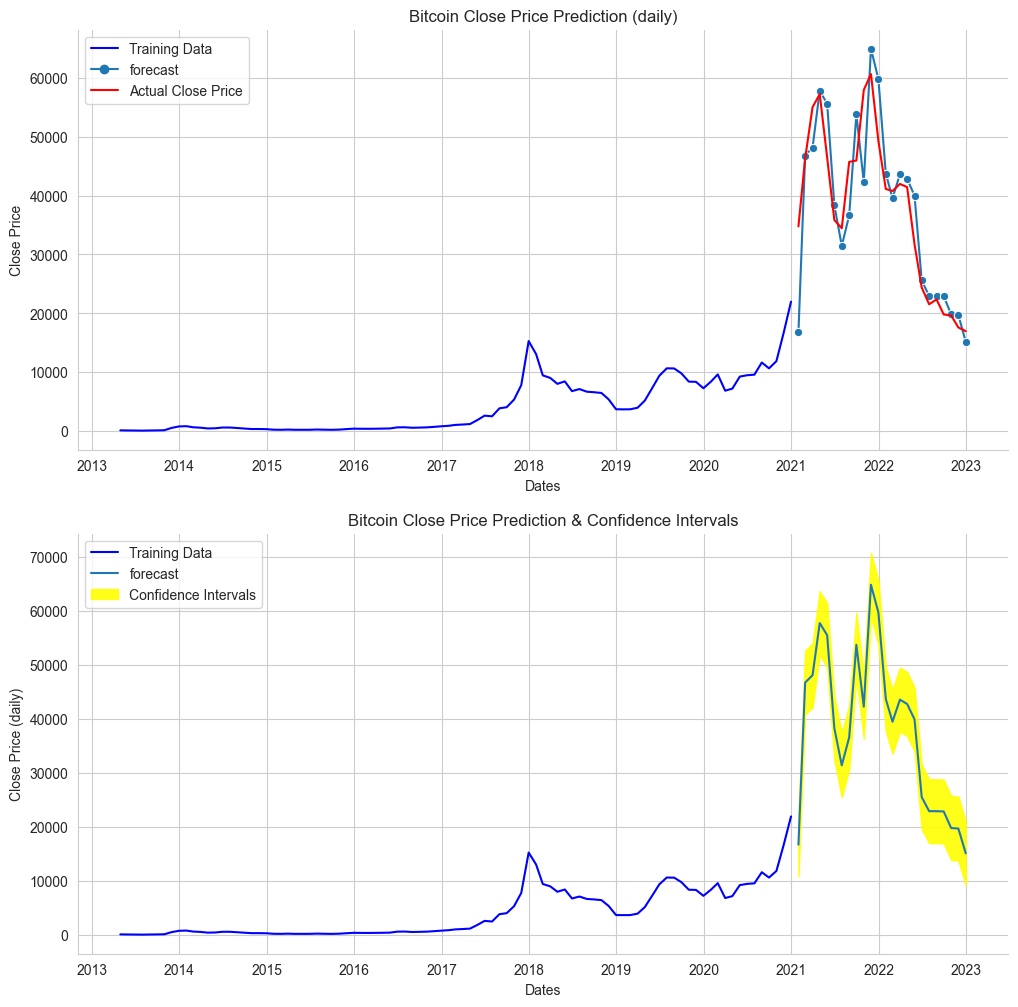

In [42]:
#https://alkaline-ml.com/pmdarima/usecases/stocks.html
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.lineplot(train_monthly, color='blue', label='Training Data', ax=axes[0])
sns.lineplot(f_data, markers=True,color='green', ax=axes[0])
sns.lineplot(test_monthly, color='red', label='Actual Close Price', ax=axes[0])

axes[0].set_title('Bitcoin Close Price Prediction (daily)')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Close Price')
axes[0].legend()

sns.lineplot(train_monthly, color='blue', label='Training Data', ax=axes[1])
sns.lineplot(f_data,color='green', ax=axes[1])
axes[1].set_title('Bitcoin Close Price Prediction & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Close Price (daily)')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_monthly.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='yellow',
                     label="Confidence Intervals")

axes[1].legend()
sns.despine()
plt.show()

In [43]:
date = [datetime(2023,1,31),datetime(2023,2,28),datetime(2023,3,31),datetime(2023,4,30)]
df=pd.DataFrame({'date':date})

In [44]:
predictions =[]
ci_intervals=[]
for i in range(1,5):
    prediction, confidence_intervals= forecast_one_step(model_monthly, n_periods=i)
    model_monthly.update(prediction)
    predictions.append(prediction)
    #print(df.iloc[i-1])
    ci_intervals.append(confidence_intervals)

In [45]:
df['predictions'] = predictions
#df.set_index('date',inplace=True)
all = pd.concat([train_monthly.to_frame(),test_monthly.to_frame(),df.set_index('date')])

In [46]:
fig = px.line(all,title='BTC Close: 4 months forecast').update_layout(xaxis_title='Date',yaxis_title='Close')
fig.show()